# 20220516 Initial Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
from importlib import reload
from imaka.analysis import plot_stats
from imaka.analysis import plot_redu
from imaka.reduce import util
from imaka.analysis import fourfilt
from astropy.stats import sigma_clipped_stats

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

import imaka.analysis.moffat as moffat
## Edit Me
from imaka.reduce.nights import reduce_2022_05_16 as redu
night = '20220516'
fld = 'Fld2'

root_dir = redu.root_dir
stats_dir = root_dir + "reduce/stats/"
plots_dir = root_dir + "reduce/plots/"
stack_dir = root_dir + "reduce/stacks/"

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Had an issue with stacking, the gfol
for key in list(redu.dict_images.keys()):
    for i in range(len(redu.dict_images[key])):
        img_num = redu.dict_images[key]
        suf = redu.dict_suffix[key]
        test_img_base = 'sta{img:03d}{suf:s}_scan'.format(img=img_num[i], suf=suf)
        
        stars = Table.read(root_dir + f'reduce/{fld}/' + test_img_base + '_clean_stars_stats_mdp.fits')
        print(f"key: {key} image {img_num[i]} stars: {len(stars)}")  

key: open image 87 stars: 965
key: open image 90 stars: 1154
key: open image 94 stars: 1446
key: open image 98 stars: 1454
key: open image 102 stars: 1158
key: open image 106 stars: 316
key: open image 110 stars: 1317
key: open image 120 stars: 1650
key: open image 124 stars: 1417
key: open image 128 stars: 1489
key: open image 137 stars: 1382
key: open image 141 stars: 1417
key: open image 145 stars: 1432
key: open image 149 stars: 1108
key: open image 153 stars: 654
key: LS image 86 stars: 1220
key: LS image 89 stars: 1224
key: LS image 92 stars: 1611
key: LS image 93 stars: 1645
key: LS image 96 stars: 1754
key: LS image 97 stars: 1806
key: LS image 100 stars: 1693
key: LS image 104 stars: 1770
key: LS image 108 stars: 1542
key: LS image 118 stars: 1721
key: LS image 122 stars: 1902
key: LS image 126 stars: 2182
key: LS image 135 stars: 2089
key: LS image 139 stars: 1861
key: LS image 143 stars: 1909
key: LS image 147 stars: 1439
key: LS image 151 stars: 1586
key: LS_new image 101 s

# 0. Plot: Single Image and starlists

In [4]:
# pick a file based on key
key = 'LS'
i = 1
#####
img_num = redu.dict_images[key]
suf = redu.dict_suffix[key]
test_img_base = 'sta{img:03d}{suf:s}_scan'.format(img=img_num[i], suf=suf)

50% EE radius = 0.450"


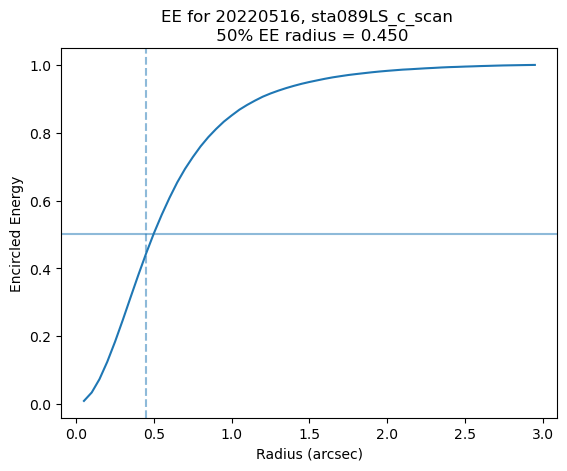

In [5]:
plot_redu.plot_ee_50(test_img_base, root_dir, fld, night)

/g/lu/data/imaka/onaga/20220516/sta/reduce/Fld2//sta089LS_c_scan_clean.fits


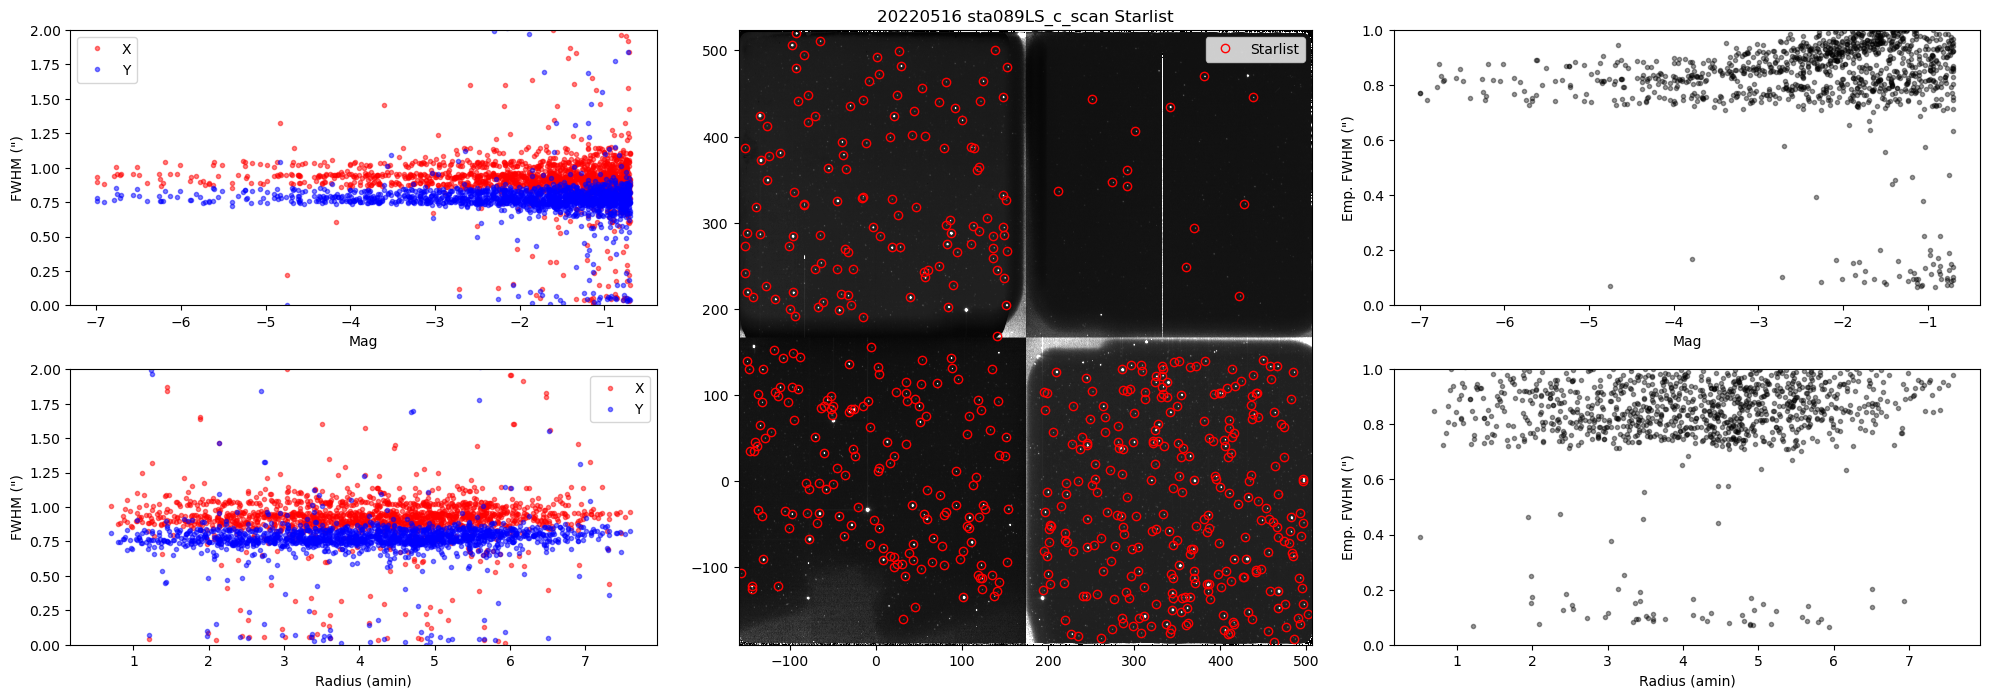

x: fwhm_x_avg = 0.94" fwhm_x_med = 0.93" fwhm_x_std = 0.07"
x: fwhm_x_avg = 0.94" fwhm_x_med = 0.93" fwhm_x_std = 0.07"


In [6]:
plot_redu.plot_starlist_stats(test_img_base, root_dir, fld, night)

In [7]:
from astropy import table
starlist = root_dir + 'reduce/Fld2/' + test_img_base + '_clean_stars_stats_mdp.fits'
stars = table.Table.read(starlist)

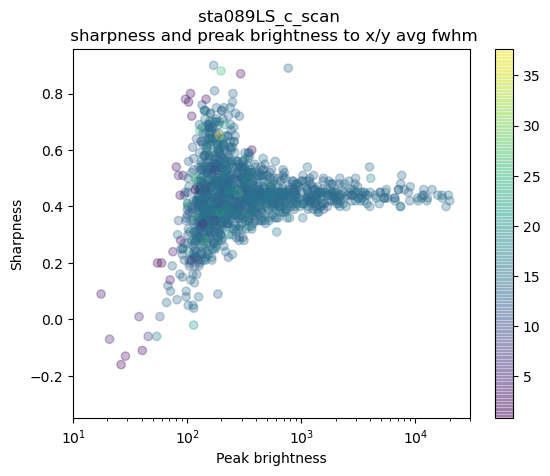

In [8]:
# num pix vs fwhm
plt.scatter(stars['peak'], stars['sharpness'], c=np.average([stars['x_fwhm'], stars['y_fwhm']], axis=0), alpha=0.3)
plt.xlim(10, 30000)
plt.xscale('log')
plt.xlabel("Peak brightness")
plt.ylabel("Sharpness")
plt.title(test_img_base+ " \n sharpness and preak brightness to x/y avg fwhm")
plt.colorbar()

# 1. Stat Plots
Various measures of starlists. These mostly depend on each individual sarlist having stats calculated.

## 1.1. Plot: Moffat profile summary

Beta vs. minor alpha and Beta vs. phi

In [9]:
stats = Table.read(root_dir + 'reduce/stats/stats_LS.fits')
print(stats.colnames)

['Image', 'starlist', 'FILTER', 'F_ORD', 'BINFAC', 'DATE_UTC', 'TIME_UTC', 'DATE_HST', 'TIME_HST', 'FWHM', 'FWHM_std', 'EE25', 'EE50', 'EE80', 'NEA', 'NEA2', 'xFWHM', 'yFWHM', 'theta', 'emp_fwhm', 'emp_fwhm_std', 'quadrant', 'Index', 'N Stars', 'N Sky', 'N Sky std', 'Amplitude', 'Amplitude std', 'Phi', 'Phi std', 'Beta', 'Beta std', 'Minor Alpha', 'Minor Alpha std', 'Major Alpha', 'Major Alpha std']


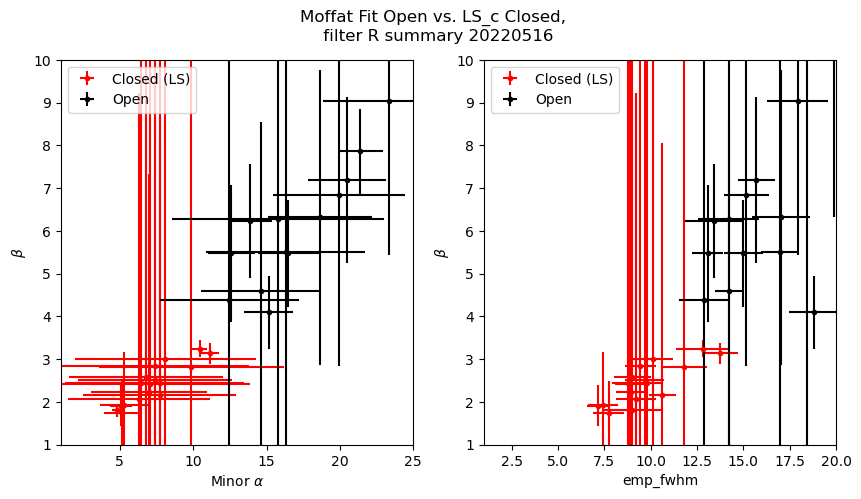

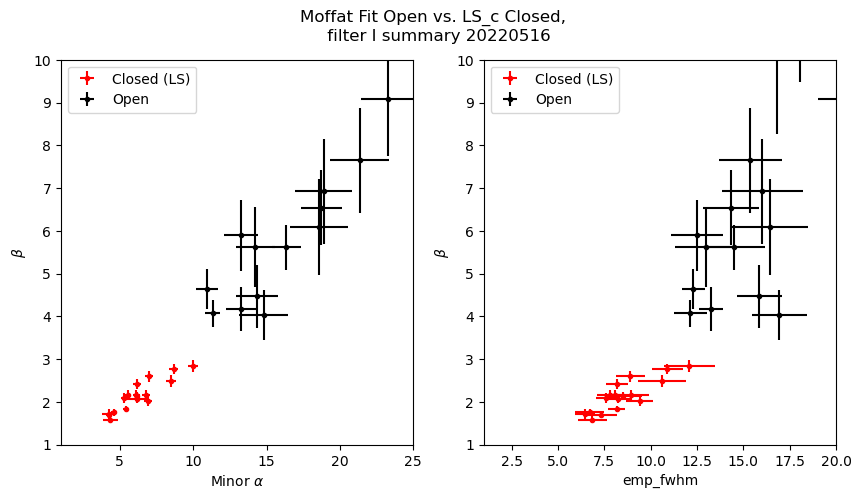

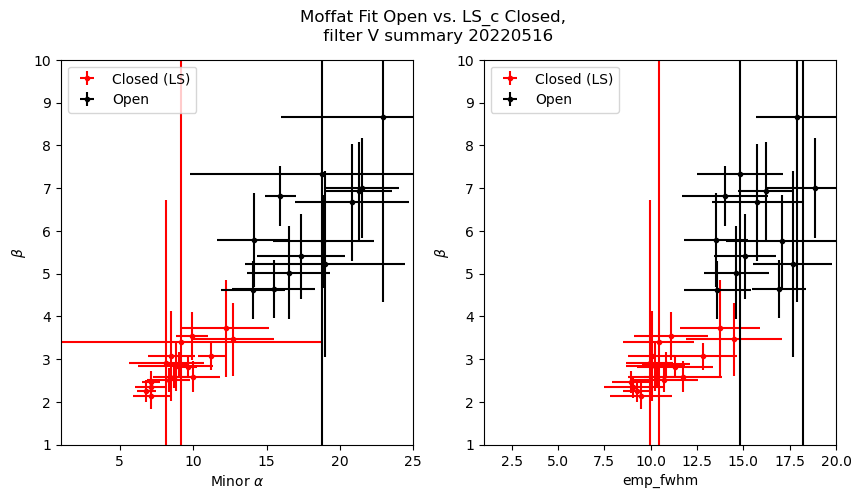

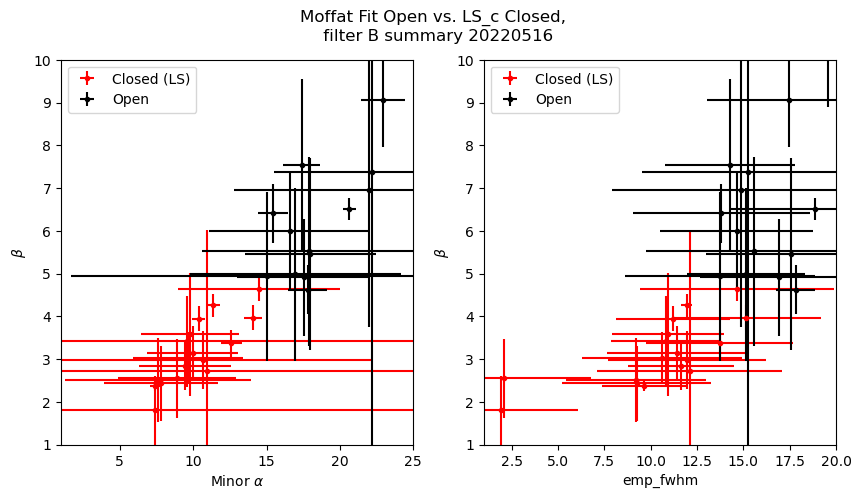

In [10]:
c_key = "LS_c"
plot_redu.plot_moffat_fit_4F("R", root_dir, c_key, fld, night)
plot_redu.plot_moffat_fit_4F("I", root_dir, c_key, fld, night)
plot_redu.plot_moffat_fit_4F("V", root_dir, c_key, fld, night)
plot_redu.plot_moffat_fit_4F("B", root_dir, c_key, fld, night)

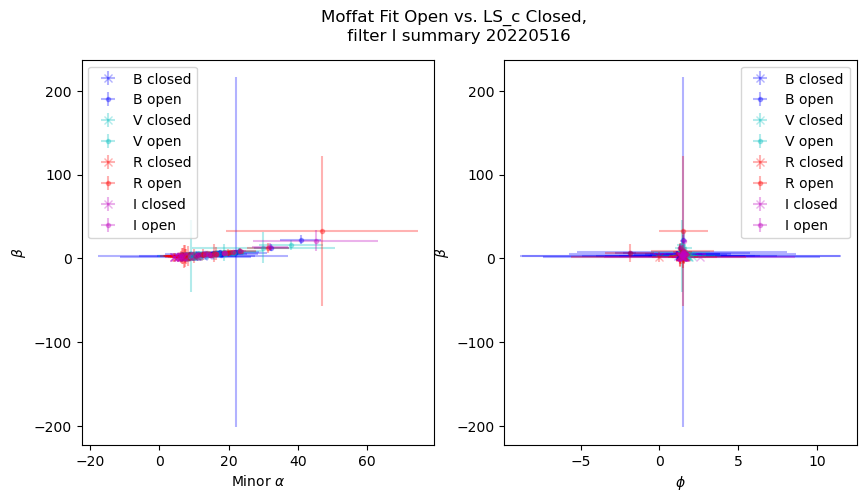

In [12]:
o_key = "_o"
c_key = "LS_c"
dict_filt = {"B":"b", "V":"c", "R":"r", "I":"m"}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
for fil_band in dict_filt.keys():

    stats_c = Table.read(f'{root_dir}reduce/stats/stats_{c_key}_{fil_band}.fits')
    stats_o = Table.read(f'{root_dir}reduce/stats/stats_{o_key}_{fil_band}.fits')
    
    ax[0].errorbar(stats_c['Minor Alpha'], stats_c['Beta'], xerr=stats_c['Minor Alpha std'], yerr=stats_c['Beta std'], fmt=dict_filt[fil_band]+"x", label=f"{fil_band} closed", ecolor=dict_filt[fil_band], alpha = 0.3)
    ax[0].errorbar(stats_o['Minor Alpha'], stats_o['Beta'], xerr=stats_o['Minor Alpha std'], yerr=stats_o['Beta std'], fmt=dict_filt[fil_band]+".", label=f"{fil_band} open", ecolor=dict_filt[fil_band], alpha = 0.3)
    ax[0].set_xlabel(r'Minor $\alpha$')
    ax[0].set_ylabel(r'$\beta$')
    ax[0].legend()

    ax[1].errorbar(stats_c['Phi'], stats_c['Beta'], xerr=stats_c['Phi std'], yerr=stats_c['Beta std'], fmt=dict_filt[fil_band]+"x", label=f"{fil_band} closed", ecolor=dict_filt[fil_band], alpha = 0.3)
    ax[1].errorbar(stats_o['Phi'], stats_o['Beta'], xerr=stats_o['Phi std'], yerr=stats_o['Beta std'], fmt=dict_filt[fil_band]+".", label=f"{fil_band} open", ecolor=dict_filt[fil_band], alpha = 0.3)
    ax[1].set_xlabel(r'$\phi$')
    ax[1].set_ylabel(r'$\beta$')
    ax[1].legend()

    plt.suptitle(f"Moffat Fit Open vs. {c_key} Closed, \n filter {fil_band} summary {night}")


[]

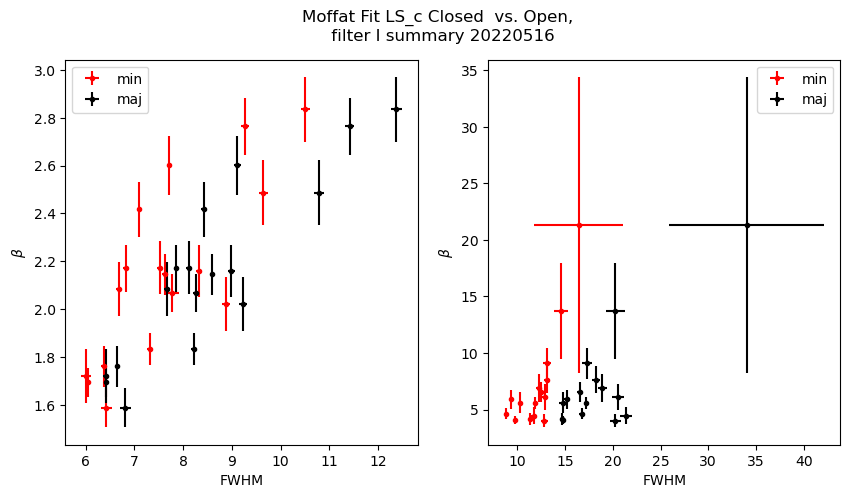

In [16]:
import imaka.analysis.moffat as moffat
fil_band = "I"
c_key = "LS_c"

# want a FWHM vs. Beta /
stats_c = Table.read(f'{root_dir}reduce/stats/stats_{c_key}_{fil_band}.fits')
stats_o = Table.read(f'{root_dir}reduce/stats/stats__o_{fil_band}.fits')

FWHM_min, sig_FWHM_min, FWHM_maj, sig_FWHM_maj = moffat.calc_mof_fwhm(f'{root_dir}reduce/stats/stats_{c_key}_{fil_band}.fits', filt=False, plate_scale=1)

plt.figure(figsize=(10,5))
plt.clf()
plt.subplot(121)
plt.errorbar(FWHM_min, stats_c['Beta'], xerr=sig_FWHM_min, yerr=stats_c['Beta std'], fmt='r.', label='min')
plt.errorbar(FWHM_maj, stats_c['Beta'], xerr=sig_FWHM_maj, yerr=stats_c['Beta std'], fmt='k.', label='maj')
plt.xlabel(r'FWHM')
plt.ylabel(r'$\beta$')
plt.legend()

FWHM_min, sig_FWHM_min, FWHM_maj, sig_FWHM_maj = moffat.calc_mof_fwhm(f'{root_dir}reduce/stats/stats__o_{fil_band}.fits', filt=False, plate_scale=1)

plt.subplot(122)
plt.errorbar(FWHM_min, stats_o['Beta'], xerr=sig_FWHM_min, yerr=stats_o['Beta std'], fmt='r.', label='min')
plt.errorbar(FWHM_maj, stats_o['Beta'], xerr=sig_FWHM_maj, yerr=stats_o['Beta std'], fmt='k.', label='maj')
plt.xlabel(r'FWHM')
plt.ylabel(r'$\beta$')
plt.legend()

plt.suptitle(f"Moffat Fit {c_key} Closed  vs. Open, \n filter {fil_band} summary {night}")
plt.plot()

### Beta vs. Mag on Stacks

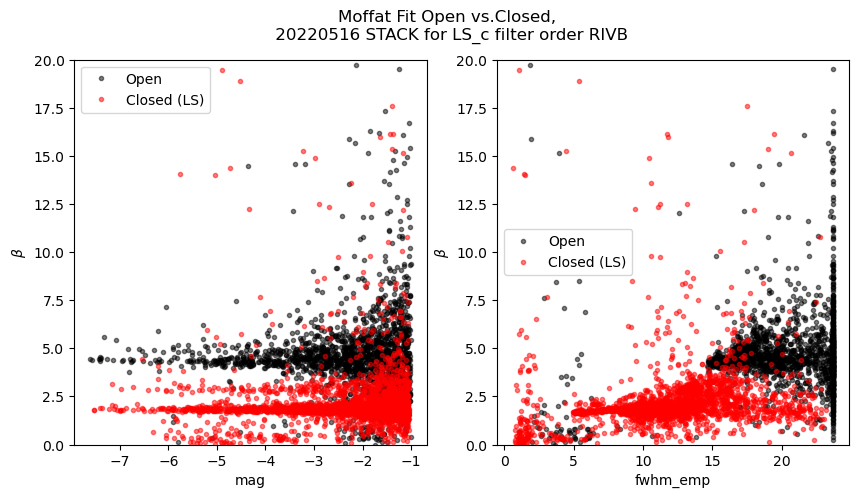

In [25]:
plot_redu.plot_beta_mag_4F_stacks(redu, filt_key = "RIVB", mdp_suff=True)

## Beta vs. FWHM for wavelength

### $Beta$ vs FWHM, Individual images
This looks at the combined individual images and standard deviation on them. 

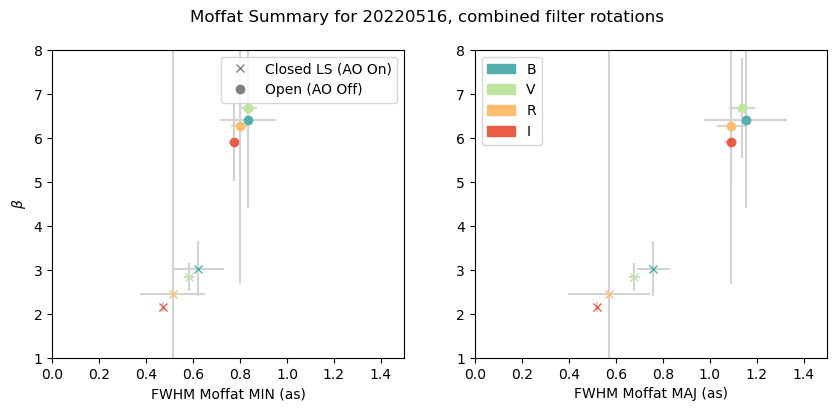

In [28]:
plot_redu.plot_fwhm_beta_4F_frames(redu, c_keys = ["LS_c", "_o"], ylim = [1,8])

### $Beta$ vs FWHM, Stacked images
This looks at the stackes images and standard deviation calculated in the moffat fitting. 

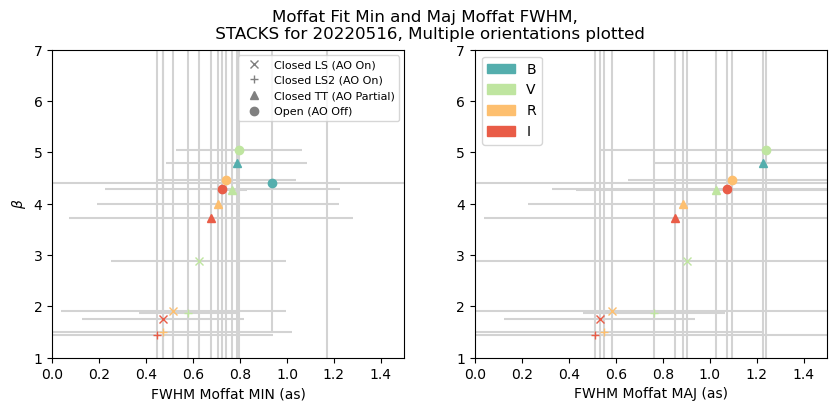

In [68]:
plot_redu.plot_fwhm_beta_4F_stack_sum(redu, c_keys = ["LS_c", "LS_c2", "TT_c","_o"])

### Jitter: Difference between MIN and MAJ
Here we look at the impact of jitter by comparing major and minor axes

['RIVB']


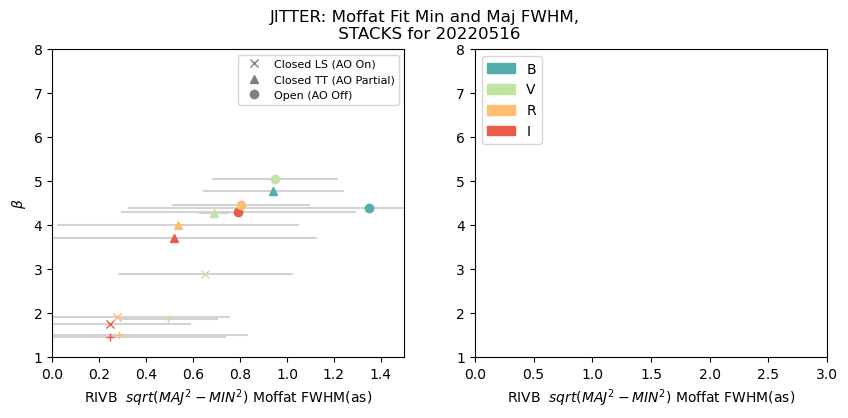

In [73]:
plot_redu.plot_jitter_4F_stack_sum(redu, ylim = [1,8])

### FA vs. FWHM
Here we want to know how the seperation from center affects FWHM from the stacked image starlists. 

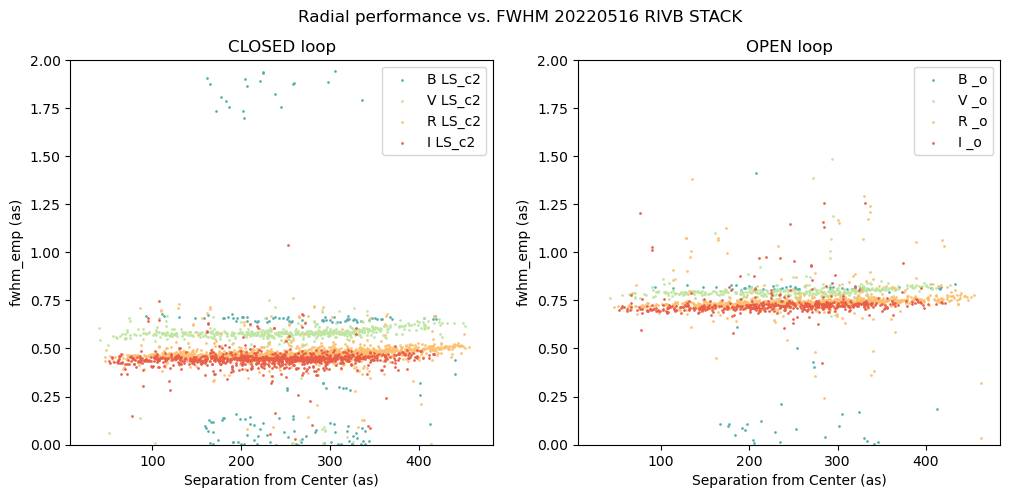

In [33]:
plot_redu.plot_fwhm_sep_4F_stacks(redu, c_key = 'LS_c2', odr ='RIVB')

## 1.2. Plot: Stats Stacking

This plots various stats wrt frame number. Edits have been made to show 4F data more intelligently.

List of plots shown:

In [22]:
stats = Table.read(root_dir + 'reduce/stats/stats_open.fits')
print(stats.colnames)
# Not 100% sure which one is FWHM for moffat fit

['Image', 'starlist', 'FILTER', 'F_ORD', 'BINFAC', 'DATE_UTC', 'TIME_UTC', 'DATE_HST', 'TIME_HST', 'FWHM', 'FWHM_std', 'EE25', 'EE50', 'EE80', 'NEA', 'NEA2', 'xFWHM', 'yFWHM', 'theta', 'emp_fwhm', 'emp_fwhm_std', 'quadrant', 'Index', 'N Stars', 'N Sky', 'N Sky std', 'Amplitude', 'Amplitude std', 'Phi', 'Phi std', 'Beta', 'Beta std', 'Minor Alpha', 'Minor Alpha std', 'Major Alpha', 'Major Alpha std']


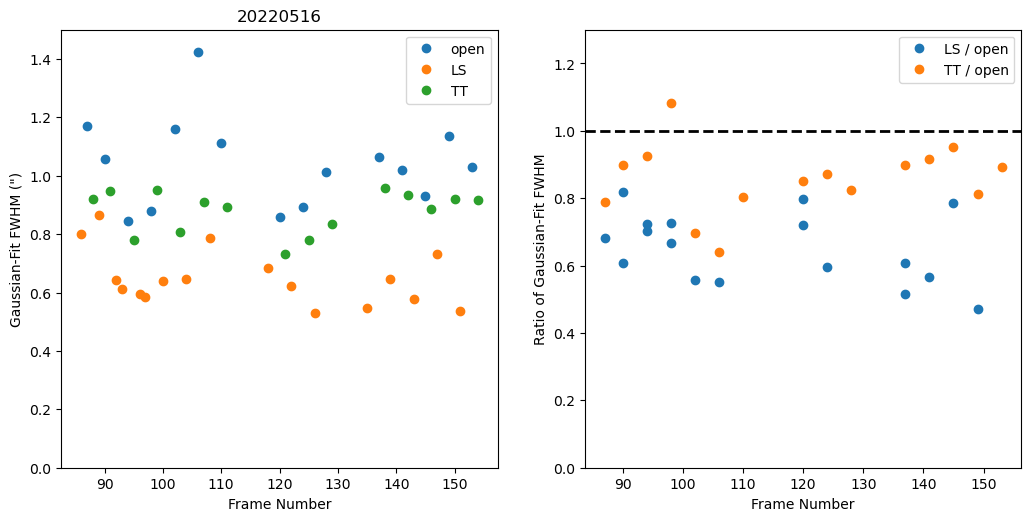

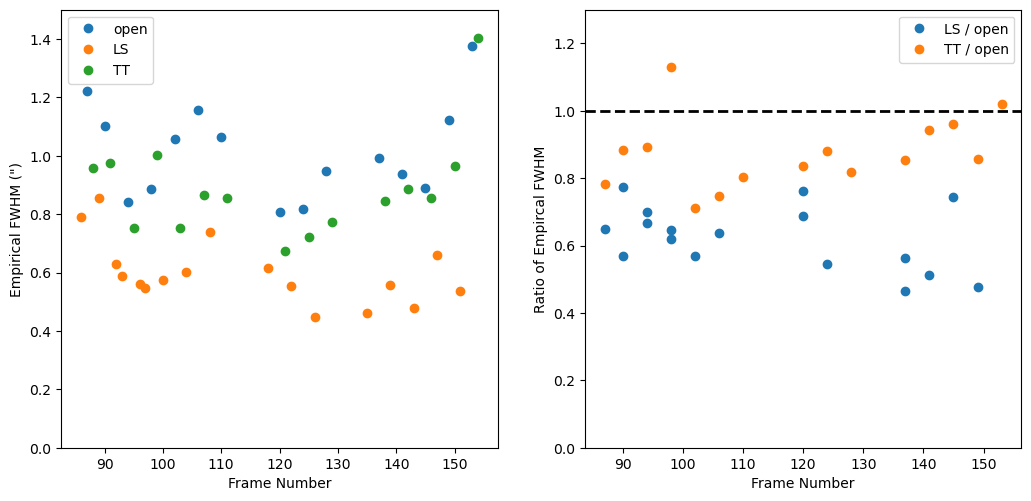

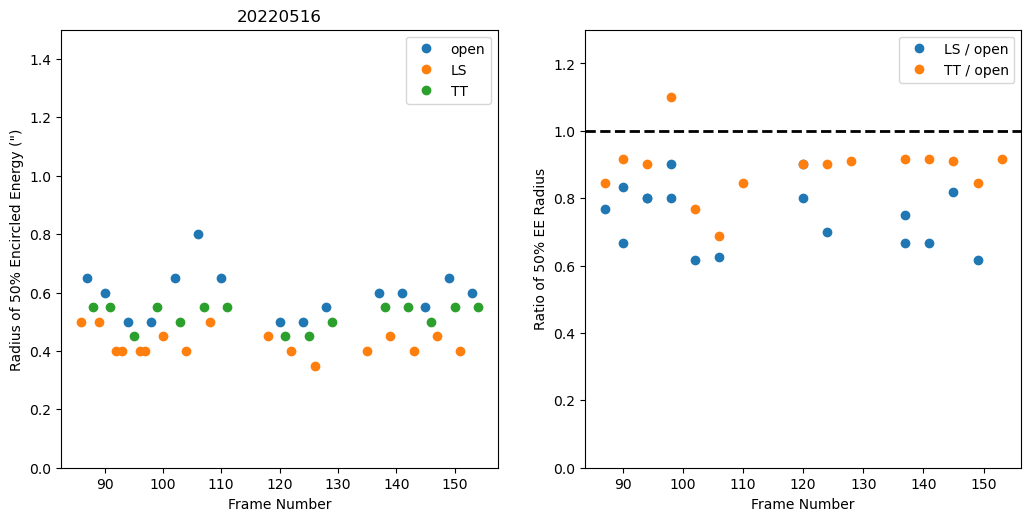

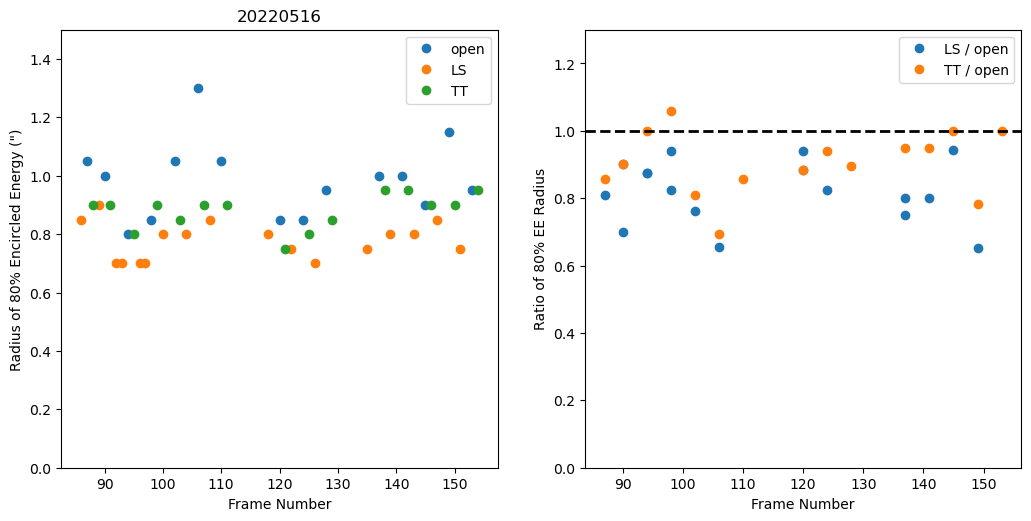

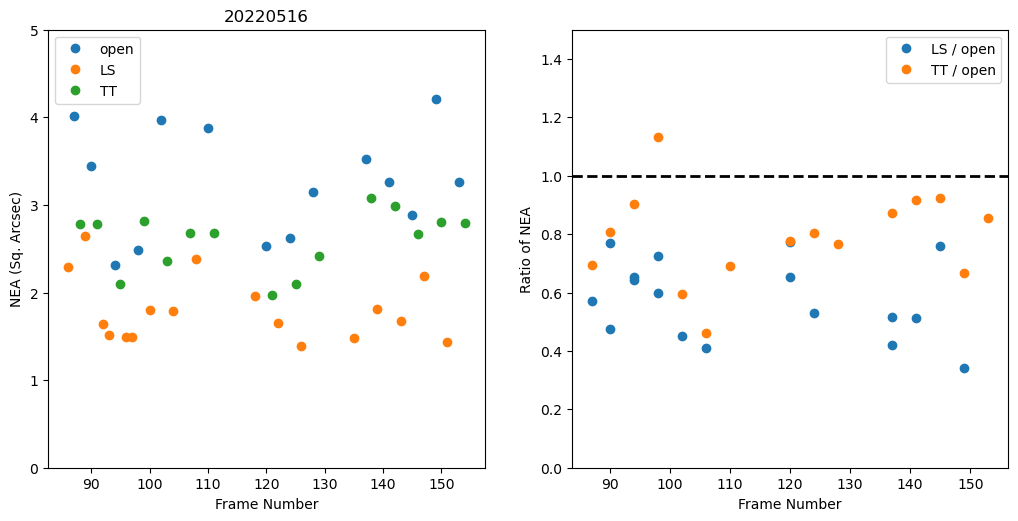

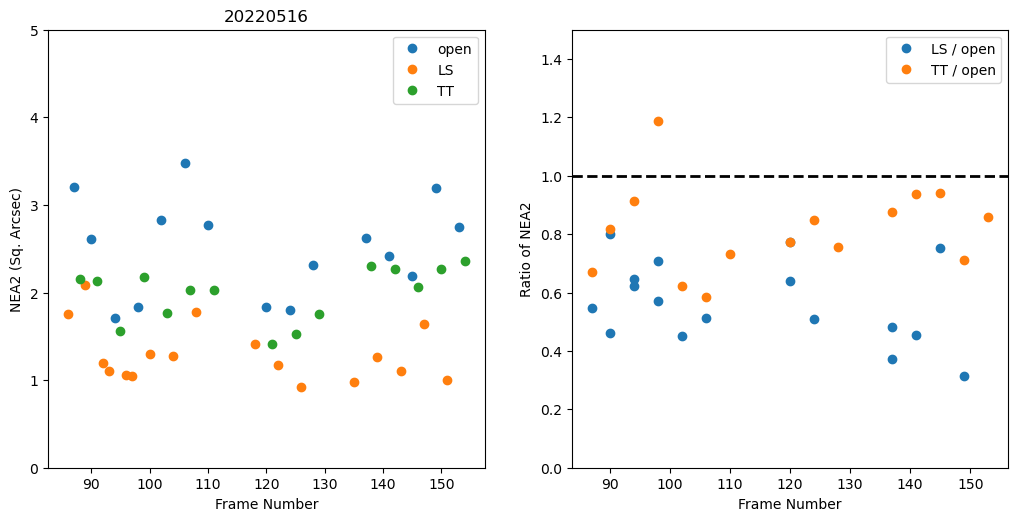

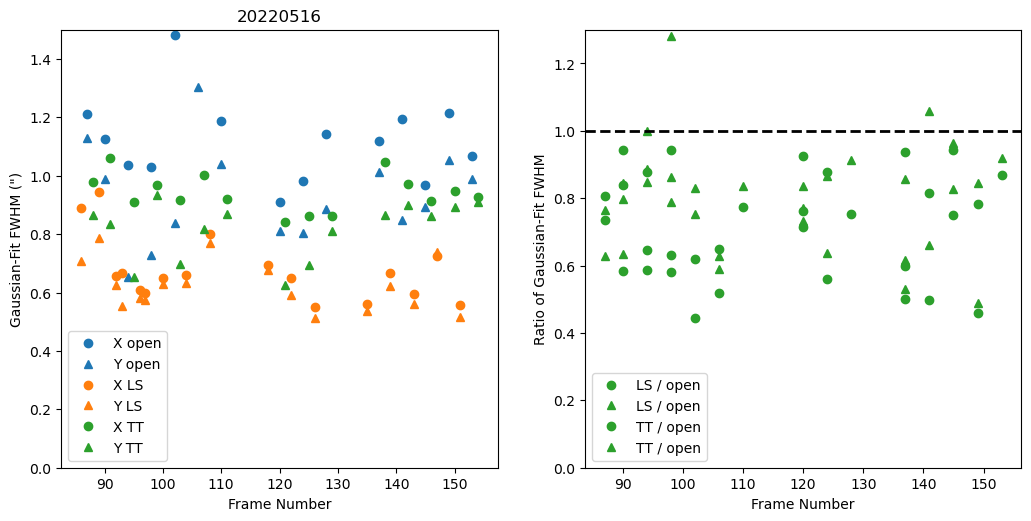

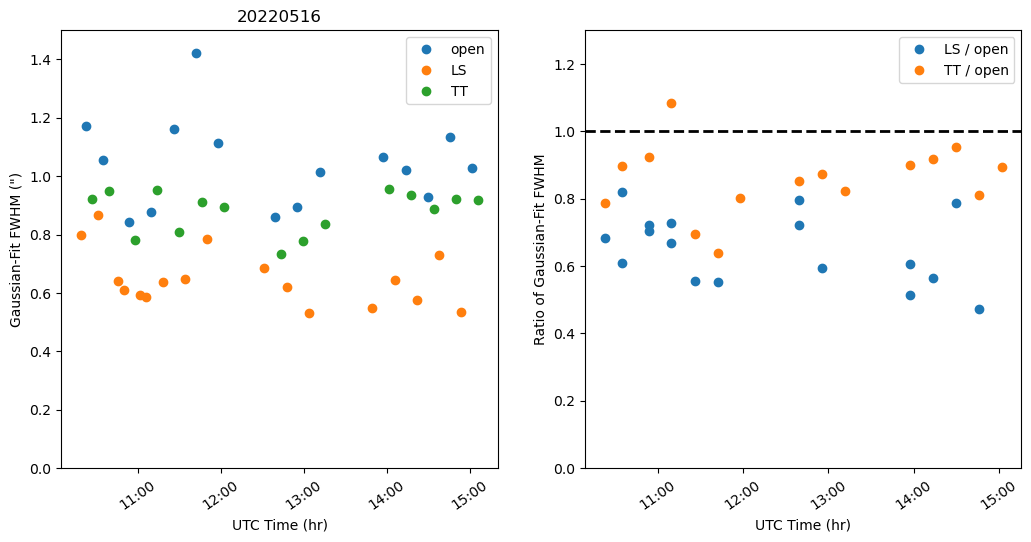

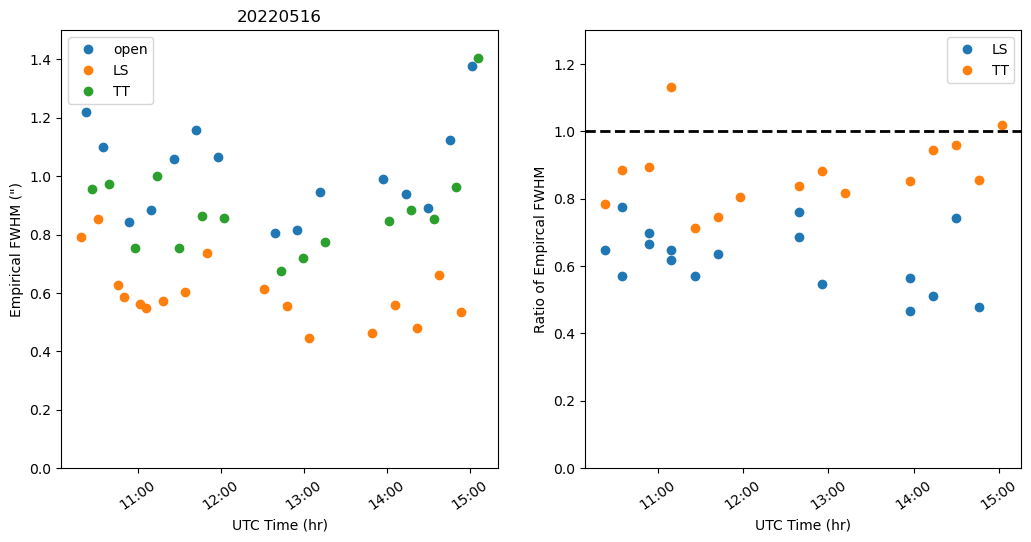

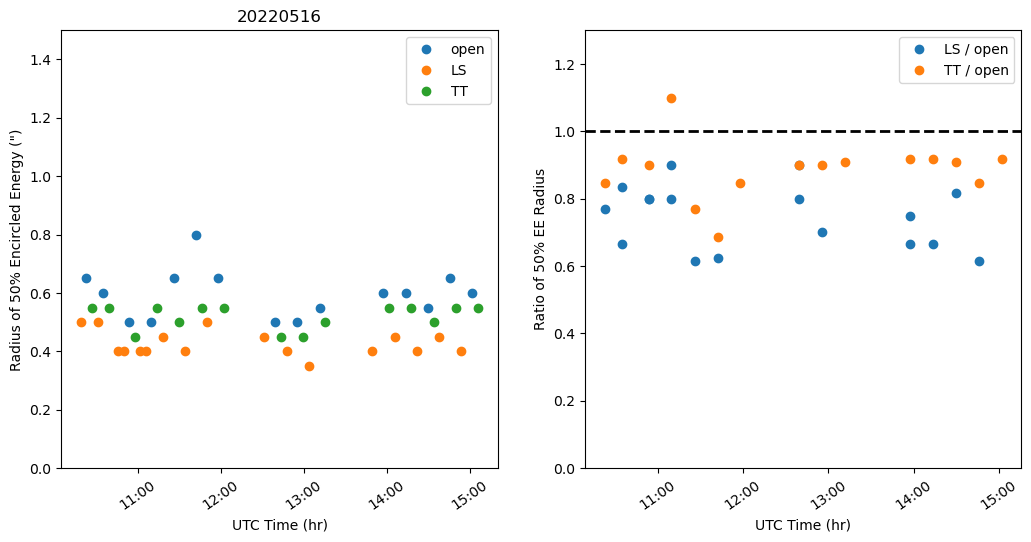

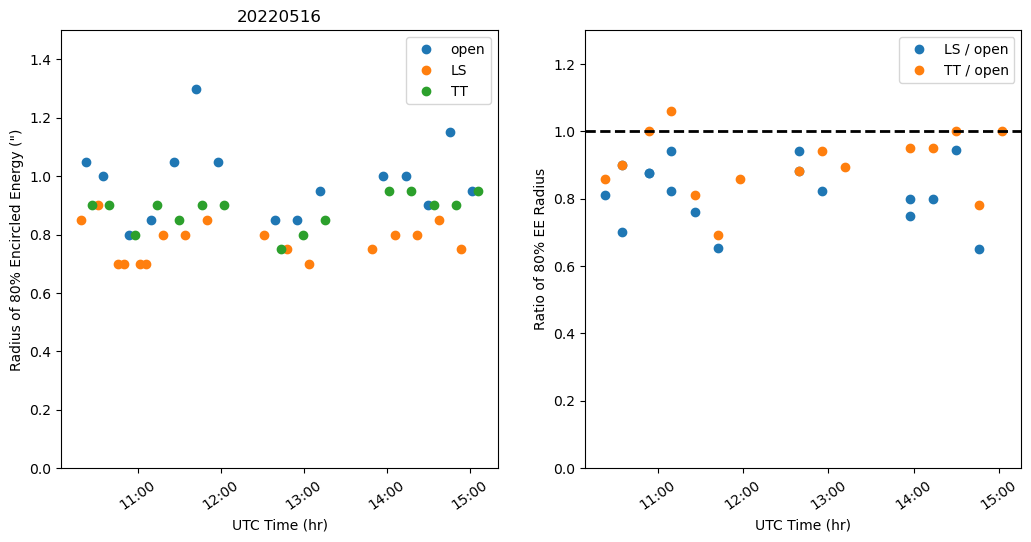

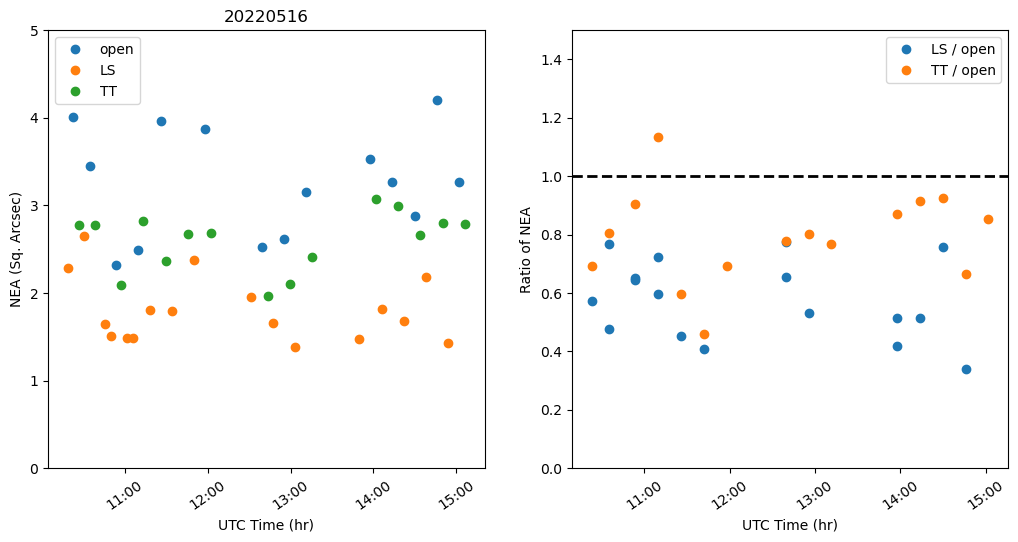

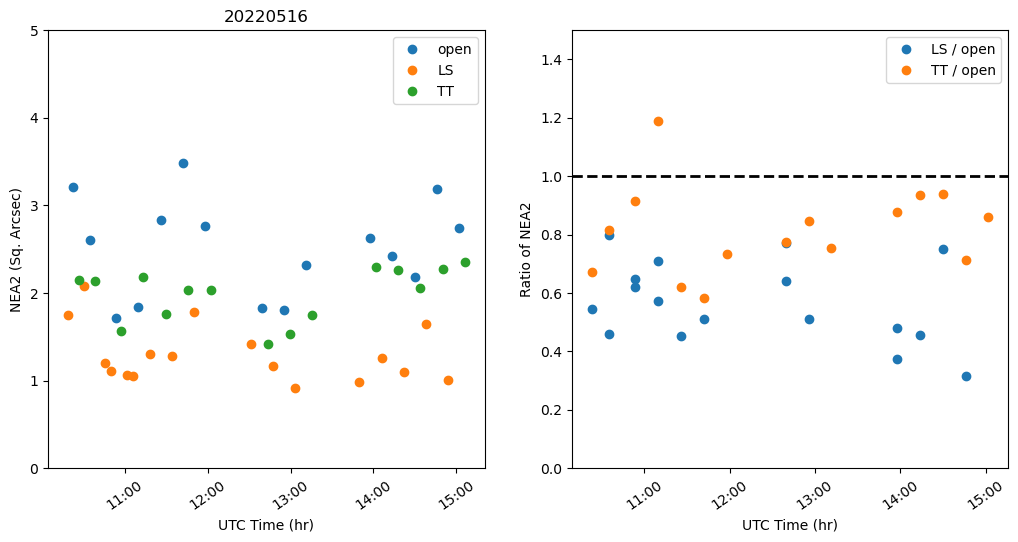

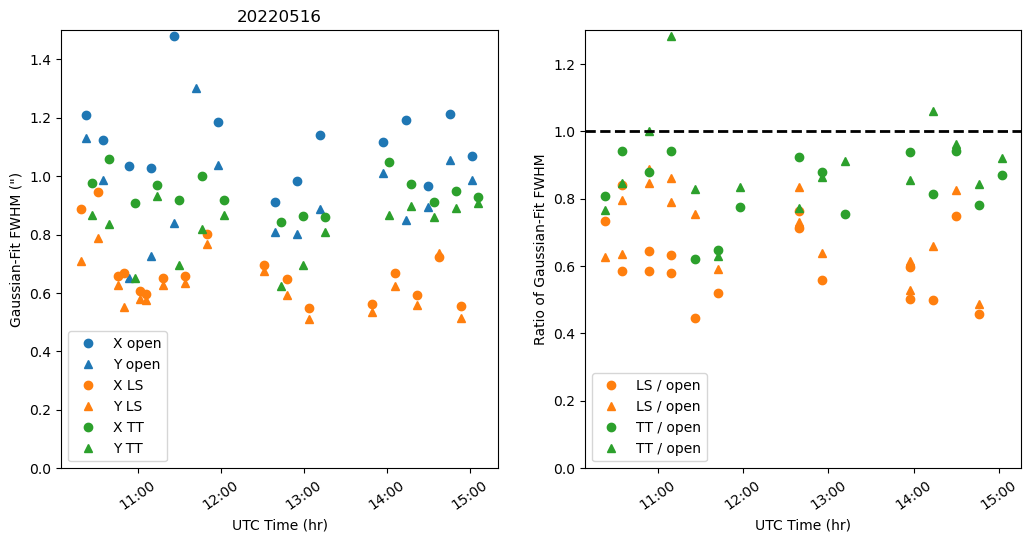

In [34]:
## Must have completed stats
suffixes = list(redu.dict_suffix.keys())
suffixes = ['open','LS', 'TT']
plot_stats.plot_stack_stats(night, suffixes, root_dir=root_dir + '../../', reduce_dir='sta/reduce/')
plt.show()

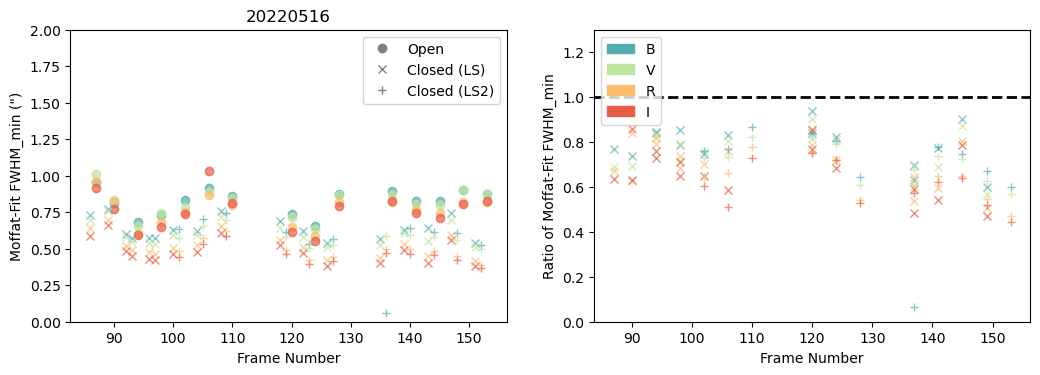

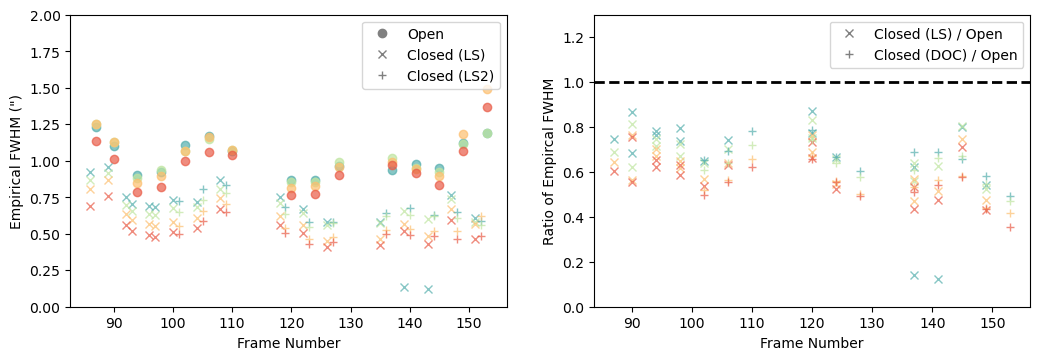

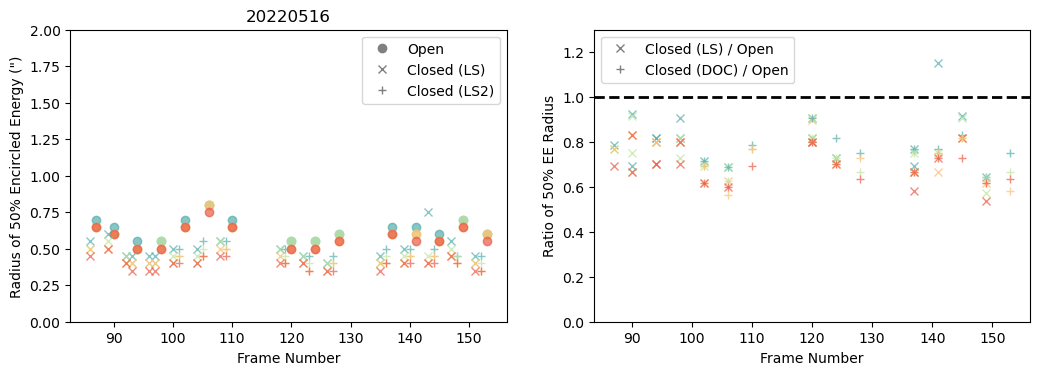

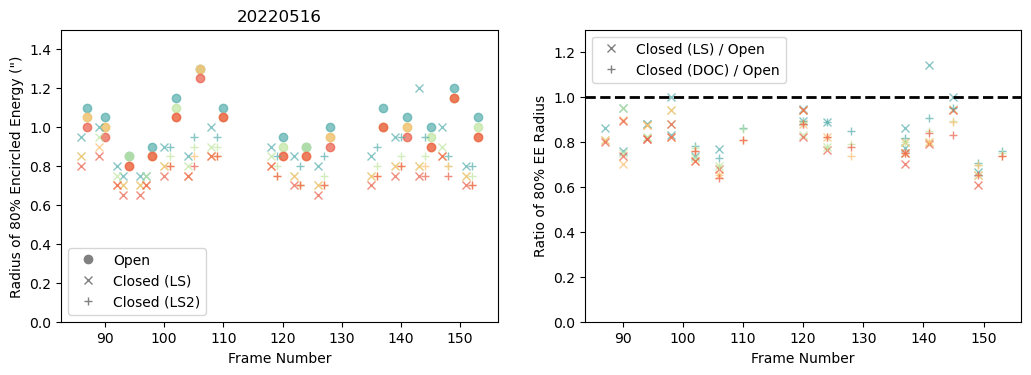

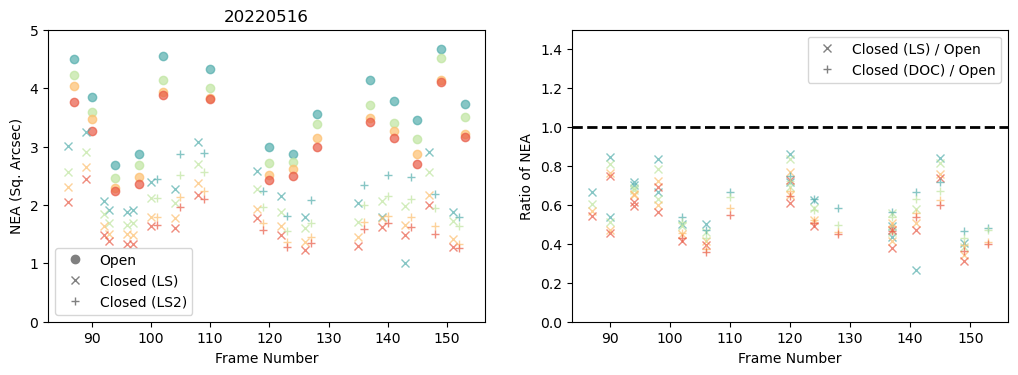

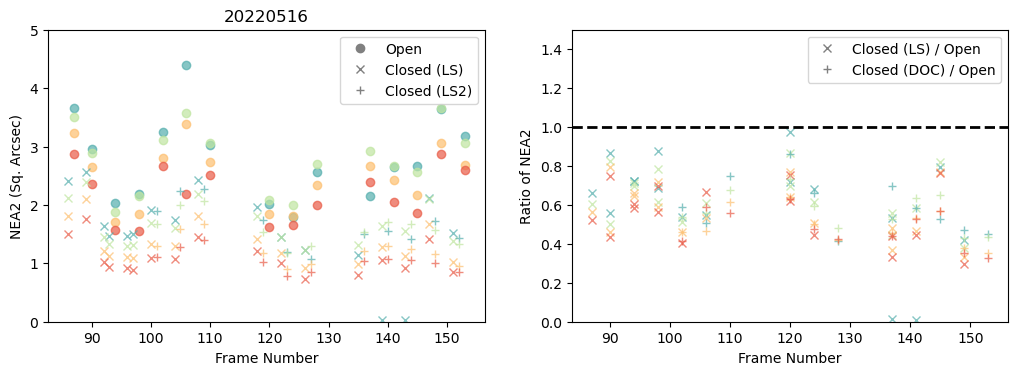

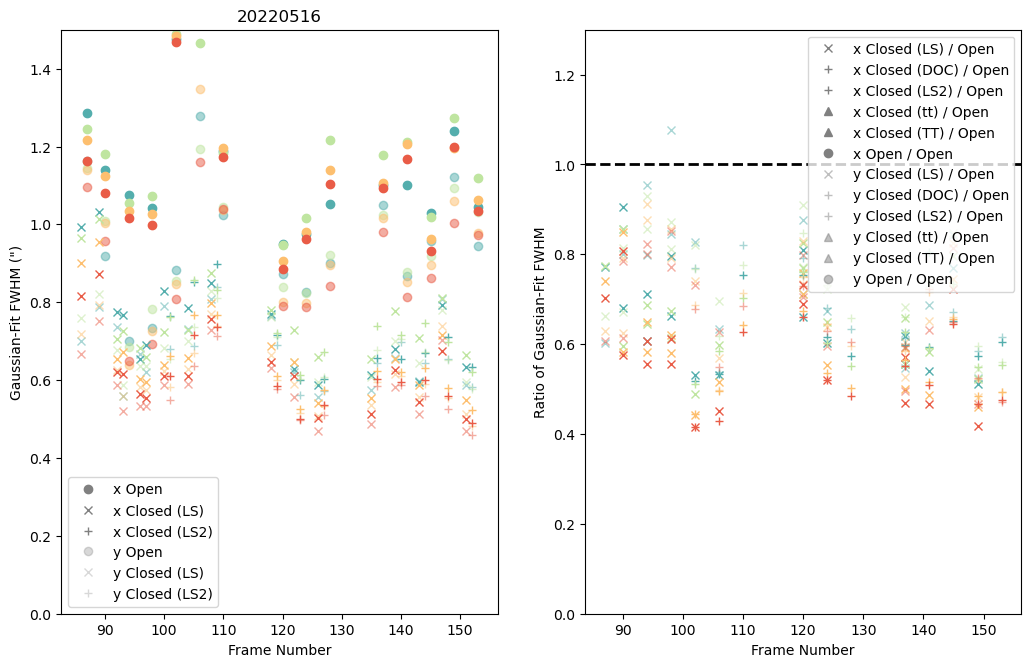

In [40]:
reload(plot_redu)
suffixes = ['_o', 'LS_c', 'LS_c2']
plot_redu.plot_stack_stats_4F_frame(night, suffixes, root_dir=root_dir + '../../', reduce_dir='sta/reduce/')
plt.show()

# 2. Aggregate Plots

## 2.1. Plot: Time Variation w/MASS-DIMM

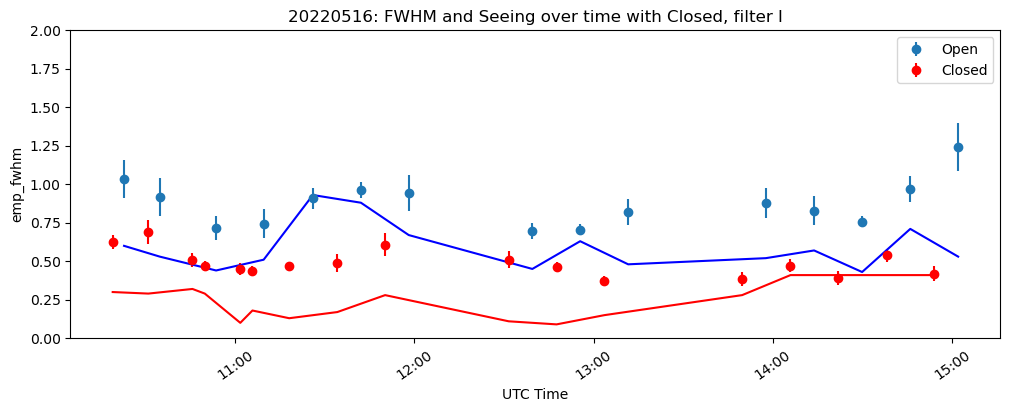

In [46]:
filt = "I"
wav = 806

open_file = f"{stats_dir}stats__o_{filt}_mdp.fits"
closed_file1 = f"{stats_dir}stats_LS_c_{filt}_mdp.fits"
plot_redu.plot_fwhmvt_nomatch_filt(open_file, closed_file1, 'emp_fwhm', f"{night}: FWHM and Seeing over time with Closed, filter {filt}", plots_dir, wav)

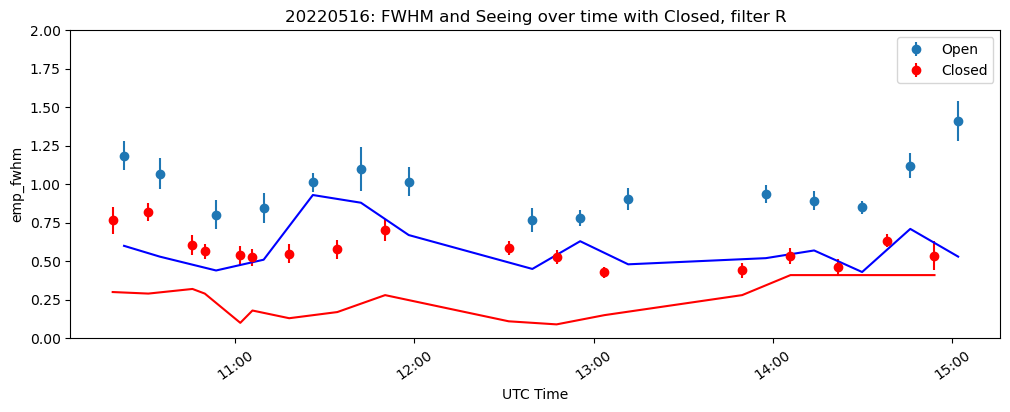

In [43]:
filt = "R"
wav = 658

open_file = f"{stats_dir}stats__o_{filt}_mdp.fits"
closed_file1 = f"{stats_dir}stats_LS_c_{filt}_mdp.fits"
plot_redu.plot_fwhmvt_nomatch_filt(open_file, closed_file1, 'emp_fwhm', f"{night}: FWHM and Seeing over time with Closed, filter {filt}", plots_dir, wav)

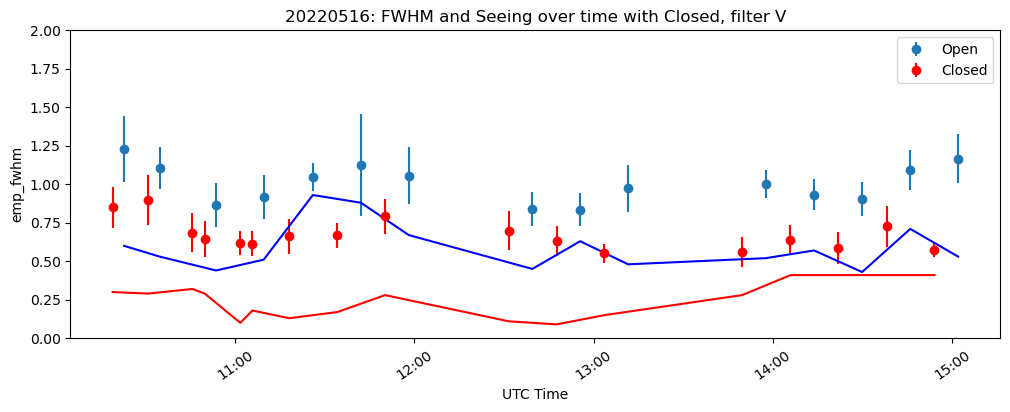

In [44]:
filt = "V"
wav = 551

open_file = f"{stats_dir}stats__o_{filt}_mdp.fits"
closed_file1 = f"{stats_dir}stats_LS_c_{filt}_mdp.fits"
plot_redu.plot_fwhmvt_nomatch_filt(open_file, closed_file1, 'emp_fwhm', f"{night}: FWHM and Seeing over time with Closed, filter {filt}", plots_dir, wav)

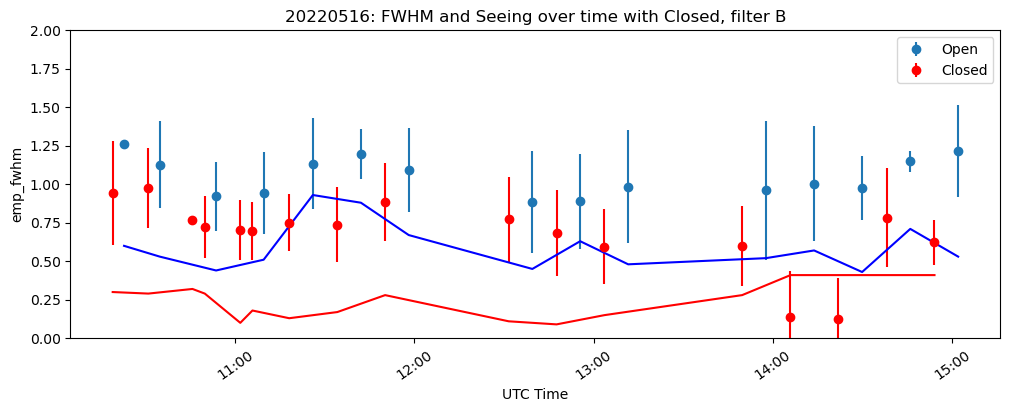

In [45]:
filt = "B"
wav = 445

open_file = f"{stats_dir}stats__o_{filt}_mdp.fits"
closed_file1 = f"{stats_dir}stats_LS_c_{filt}_mdp.fits"
plot_redu.plot_fwhmvt_nomatch_filt(open_file, closed_file1, 'emp_fwhm', f"{night}: FWHM and Seeing over time with Closed, filter {filt}", plots_dir, wav)

In [69]:
list(redu.dict_suffix.keys())

['open_BRIV', 'LS_BRIV', 'docz_BRIV', 'open_RIVB', 'LS_RIVB', 'docz_RIVB']

## 2.2. Plot: CDF of Moffat FWHM

This fuction takes in files, and for each, calculates a FWHM. The minor and major axises are then plotted.

Plate scale is not hard-coded or mentioned... not sure why this pixel scale is off yet [TODO]

/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats__o_B_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c_B_mdp.fits


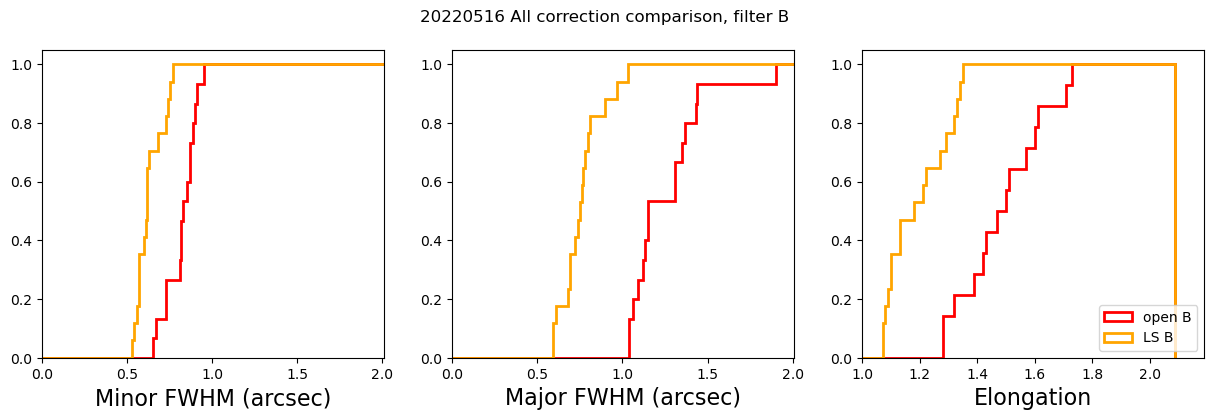

In [47]:
f_band = "B"

files = [f"{stats_dir}stats__o_{f_band}_mdp.fits", f"{stats_dir}stats_LS_c_{f_band}_mdp.fits"]
labels = ['open '+ f_band, 'LS ' + f_band, 'docz ' + f_band]
colors = ['red', 'orange', 'green', 'blue', 'lightgreen', 'cyan']
plot_stats.comp_cdf(files, labels, colors)
plt.suptitle(f"{night} All correction comparison, filter {f_band}")
plt.show()

/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats__o_B_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats__o_V_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats__o_R_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats__o_I_mdp.fits


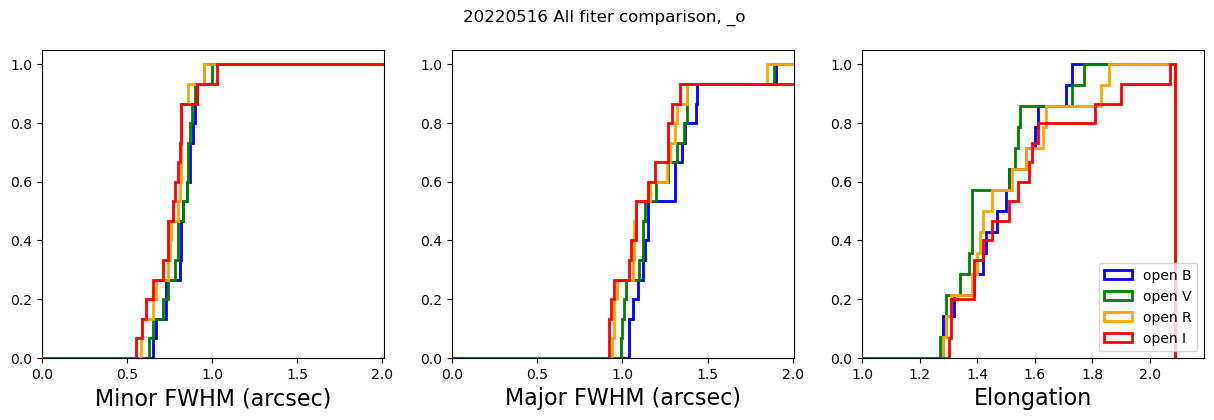

In [49]:
suff = "_o"

files = [f"{stats_dir}stats_{suff}_B_mdp.fits", f"{stats_dir}stats_{suff}_V_mdp.fits", f"{stats_dir}stats_{suff}_R_mdp.fits",f"{stats_dir}stats_{suff}_I_mdp.fits"]
labels = ['open B', 'open V', 'open R', 'open I']
colors = ['blue', 'green', 'orange', 'red']
plot_stats.comp_cdf(files, labels, colors)
plt.suptitle(f"{night} All fiter comparison, {suff}")
plt.show()

/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_TT_c_B_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_TT_c_V_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_TT_c_R_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_TT_c_I_mdp.fits


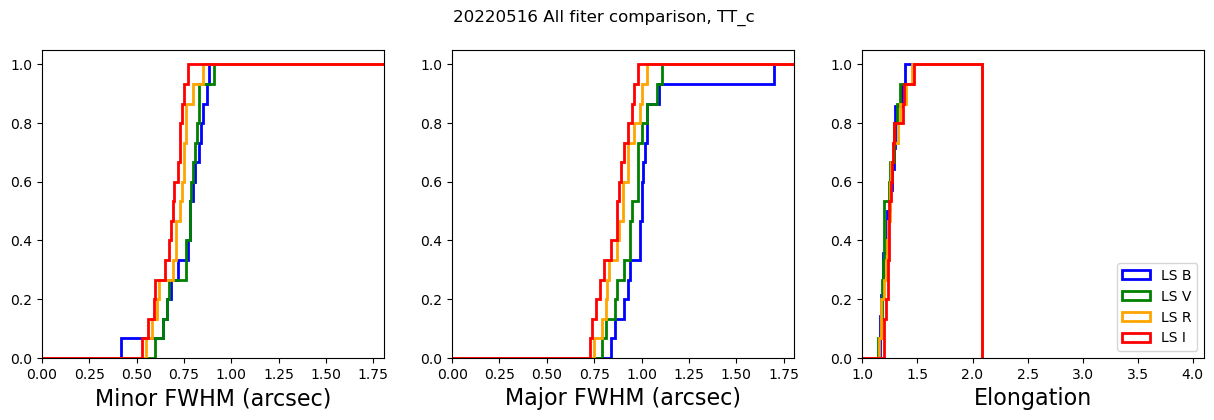

In [51]:
suff = "TT_c"

files = [f"{stats_dir}stats_{suff}_B_mdp.fits", f"{stats_dir}stats_{suff}_V_mdp.fits", f"{stats_dir}stats_{suff}_R_mdp.fits",f"{stats_dir}stats_{suff}_I_mdp.fits"]
labels = ['LS B', 'LS V', 'LS R', 'LS I']
colors = ['blue', 'green', 'orange', 'red']
plot_stats.comp_cdf(files, labels, colors)
plt.suptitle(f"{night} All fiter comparison, {suff}")
plt.show()

/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c_B_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c_V_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c_R_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c_I_mdp.fits


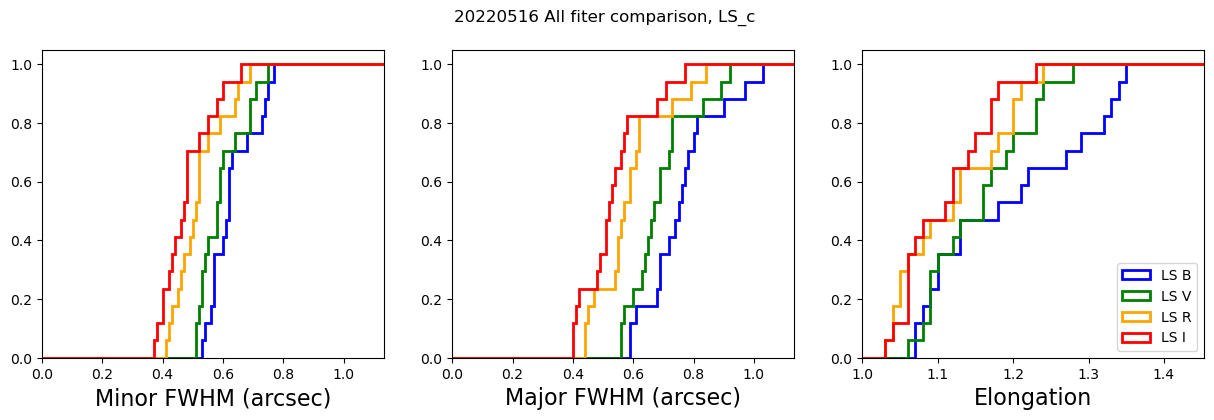

In [48]:
suff = "LS_c"

files = [f"{stats_dir}stats_{suff}_B_mdp.fits", f"{stats_dir}stats_{suff}_V_mdp.fits", f"{stats_dir}stats_{suff}_R_mdp.fits",f"{stats_dir}stats_{suff}_I_mdp.fits"]
labels = ['LS B', 'LS V', 'LS R', 'LS I']
colors = ['blue', 'green', 'orange', 'red']
plot_stats.comp_cdf(files, labels, colors)
plt.suptitle(f"{night} All fiter comparison, {suff}")
plt.show()

/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c2_B_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c2_V_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c2_R_mdp.fits
/g/lu/data/imaka/onaga/20220516/sta/reduce/stats/stats_LS_c2_I_mdp.fits


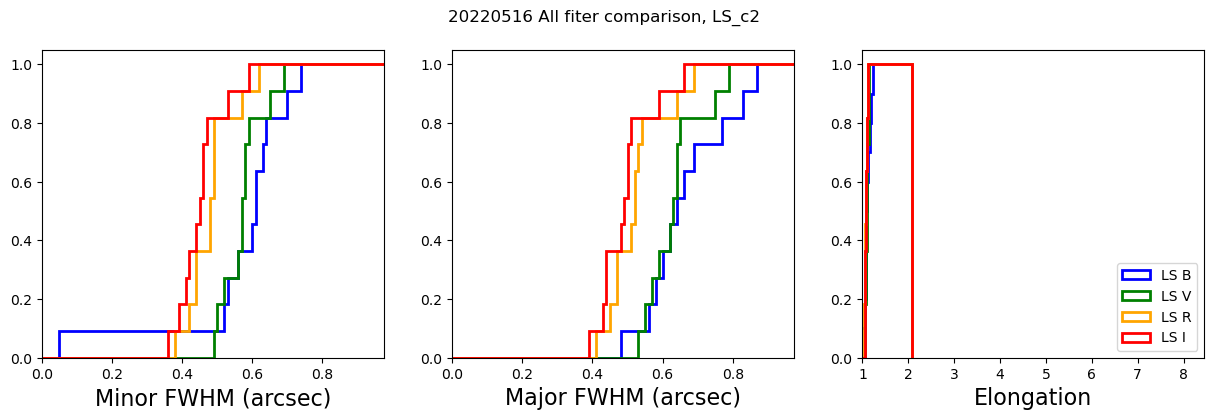

In [50]:
suff = "LS_c2"

files = [f"{stats_dir}stats_{suff}_B_mdp.fits", f"{stats_dir}stats_{suff}_V_mdp.fits", f"{stats_dir}stats_{suff}_R_mdp.fits",f"{stats_dir}stats_{suff}_I_mdp.fits"]
labels = ['LS B', 'LS V', 'LS R', 'LS I']
colors = ['blue', 'green', 'orange', 'red']
plot_stats.comp_cdf(files, labels, colors)
plt.suptitle(f"{night} All fiter comparison, {suff}")
plt.show()

# 3. Four Filter Analysis Plots

In [52]:
root = stats_dir

files_c = [root+"stats_LS_c_B.fits", root+"stats_LS_c_V.fits", root+"stats_LS_c_R.fits", root+"stats_LS_c_I.fits"]
files_o = [root+"stats__o_B.fits", root+"stats__o_V.fits", root+"stats__o_R.fits", root+"stats__o_I.fits"]
wav = [445, 551, 658, 806]
fourfilt.stack_all(table_list, open_close_list, filter_list)
# not 100% sure how to use this one...

NameError: name 'table_list' is not defined

## 3.1. Plot: 4F Correction Factor

Near-simeltaneous AO-off and AO-on data in each filter shows the variation in amount of correction with changing wavelength. 

What is plotted? Median FWHM \* ps for the listed files. Done for moffat FWHM. The original Function in fourfilt.py seems to be recomputing the moffat FWHM...
- Left: Performance for AO-off (blue) and AO-on (red), showing minor FWHM (circles) and major FWHM (squares) at each observation band.
- Right: Ratio of AO-off to AO-on FWHM for each filter, shown both for minor (circles) and major (squares) axes.

Plate scale (ps) was originally hard coded to 0.12





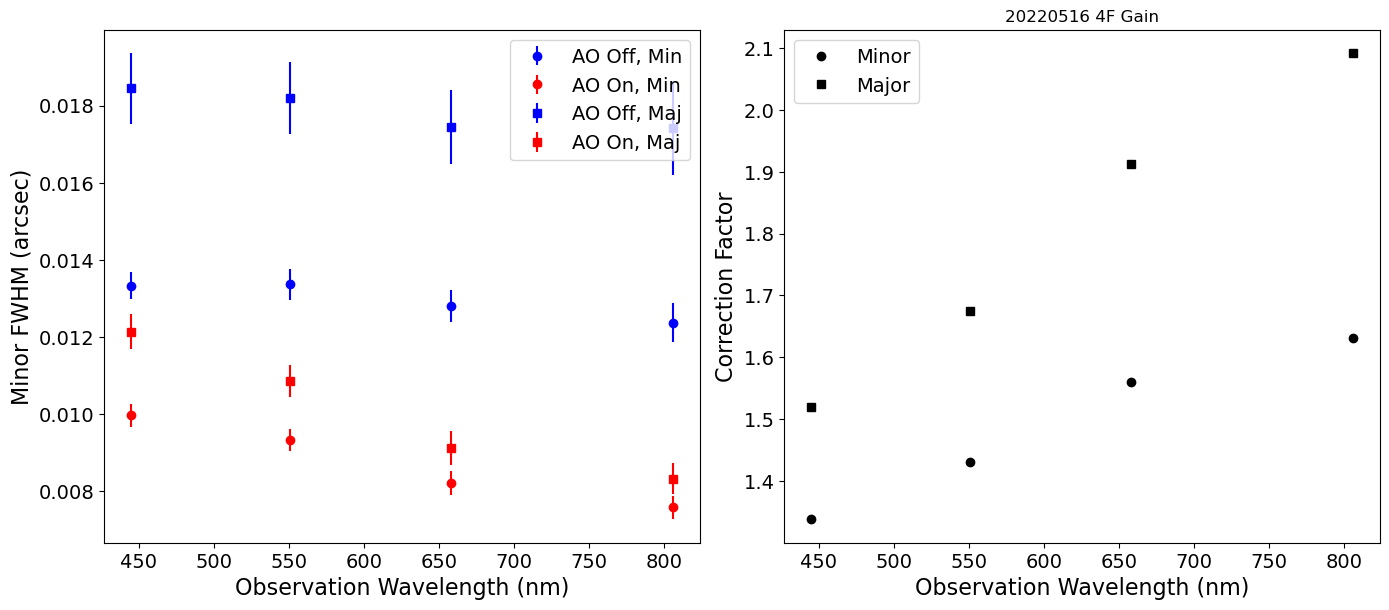

In [53]:
reload(fourfilt)
fourfilt.plot_gain(files_o, files_c, ps = 0.063) 
plt.title(f"{night} 4F Gain")
plt.show()

## 3.2. Plot: 4F Dependence Model
(Copied from four filter Analysis.ipynb)

GLAO correction is expected to be a function of wavelength. The figure below shows median minor FWHM at variuos wavelengths for AO-off (blue) and AO-on (red) data.  The data have been fit to a power-law model of the form: $f(x)=A(\frac{x}{x_o})^{-\alpha}$

With $A$, $x_o$, and $\alpha$ as free parameters

Each data set is shown in circle points with errorbars, with the best fit model (weighted with uncertainties) in solid lines. The corresponding $\alpha$ and $\chi^2$ are shown in the same color as the matching data set. In this case, the chi squared is the same as the reduced chi squared (4 data points - 3 free parameters = 1 degree of freedom).


χ$^2$=0.63
χ$^2$=1.07
α=0.12
α=0.48


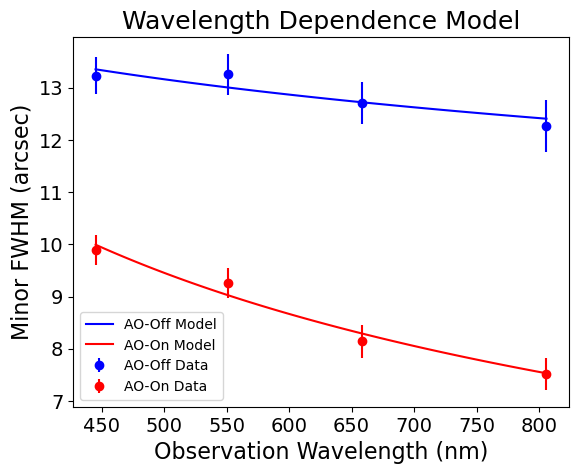

In [54]:
reload(fourfilt)
fourfilt.power_model(files_o, files_c, ps=1.0)

In [ ]:
# alpha and beta as a function of wavelength

# Field Variability

In [19]:
from importlib import reload
reload(plot_stats)

<module 'imaka.analysis.plot_stats' from '/u/eden/code/imaka/imaka/analysis/plot_stats.py'>

In [57]:
# pick a file based on key
key = 'open'
i = 4
#####
img_num = redu.dict_images[key]
suf = redu.dict_suffix[key]
test_img_base = 'sta{img:03d}{suf:s}_scan'.format(img=img_num[i], suf=suf)

### Single exposure

sta096LS_c_scan
Median FWHM           = 0.472"
Median FWHM (clipped) = 0.472"
Mean FWHM             = 22.361"
Mean FWHM (clipped)   = 0.475"
Stddev FWHM           = 901.371"
Stddev FWHM (clipped) = 0.048"


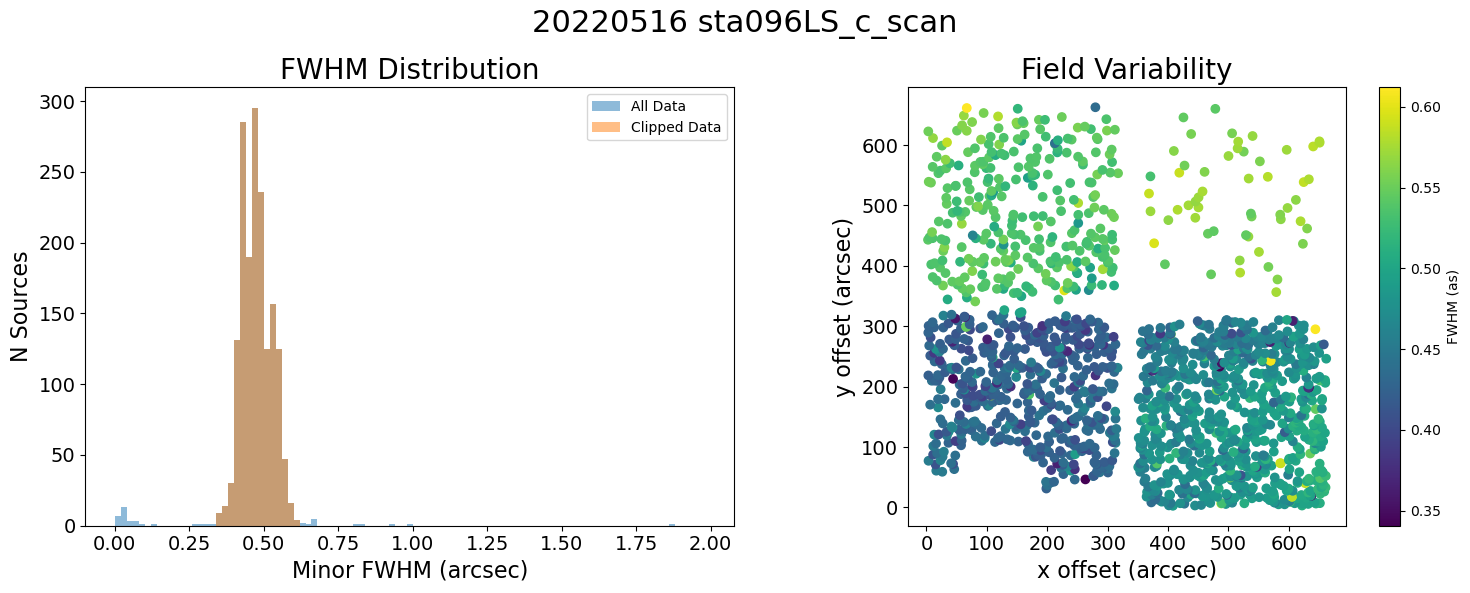

In [56]:
print(test_img_base)
img_file = root_dir + 'reduce/Fld2/' + test_img_base + '_clean.fits'
starlist = root_dir + 'reduce/Fld2/' + test_img_base + '_clean_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, night +" "+ test_img_base )

sta102_o_scan
Median FWHM           = 0.759"
Median FWHM (clipped) = 0.758"
Mean FWHM             = 0.839"
Mean FWHM (clipped)   = 0.759"
Stddev FWHM           = 1.983"
Stddev FWHM (clipped) = 0.038"


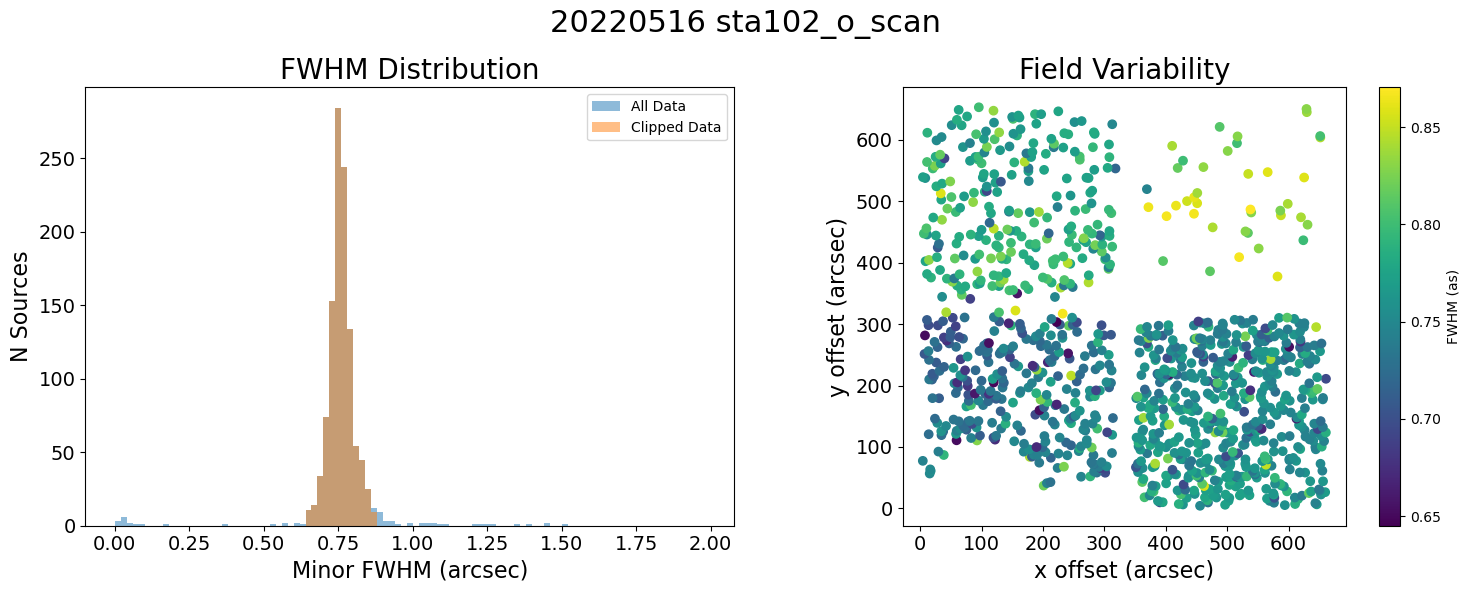

In [58]:
print(test_img_base)
img_file = root_dir + 'reduce/Fld2/' + test_img_base + '_clean.fits'
starlist = root_dir + 'reduce/Fld2/' + test_img_base + '_clean_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, night +" "+ test_img_base)

### Open Loop

Median FWHM           = 0.742"
Median FWHM (clipped) = 0.741"
Mean FWHM             = 1.142"
Mean FWHM (clipped)   = 0.749"
Stddev FWHM           = 3.684"
Stddev FWHM (clipped) = 0.037"


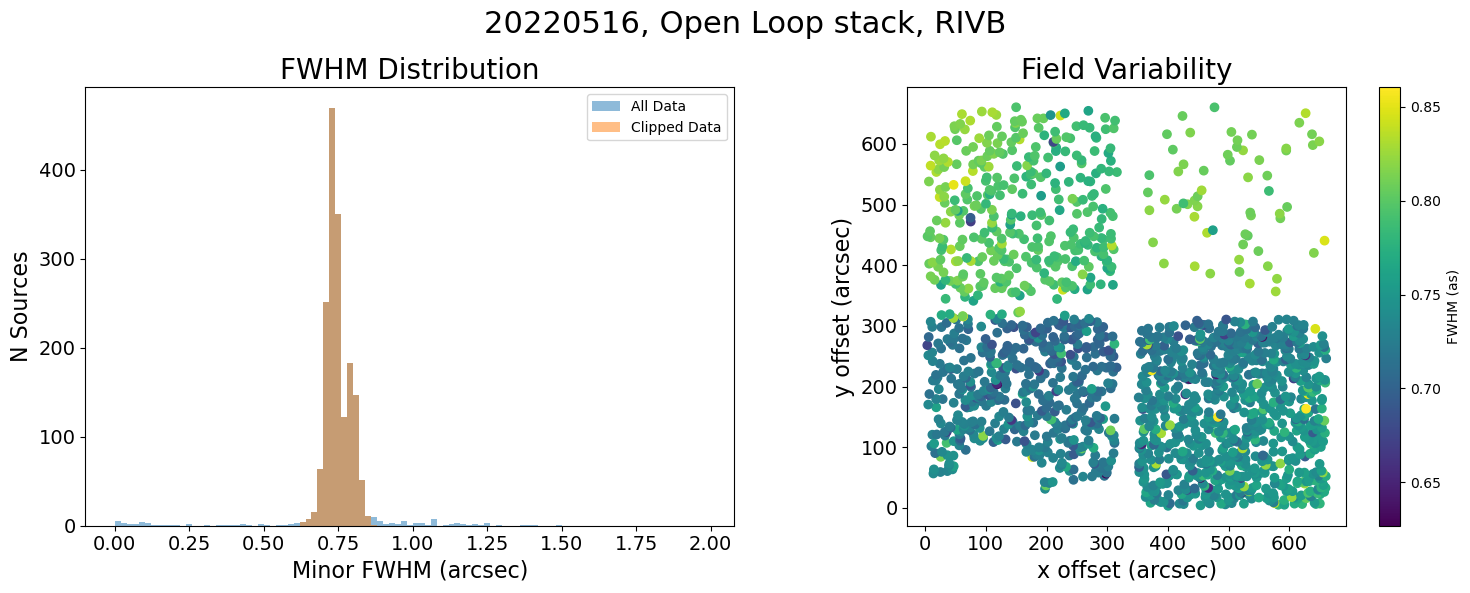

In [59]:
filt = 'RIVB'
img_file = stack_dir + f'fld2_stack__o_{filt}.fits' 
starlist = stack_dir + f'fld2_stack__o_{filt}_stars_stats_mdp.fits' 
plot_stats.plot_var(img_file, starlist, f"{night}, Open Loop stack, {filt}")

### Closed (LS)

Median FWHM           = 0.503"
Median FWHM (clipped) = 0.502"
Mean FWHM             = 14.105"
Mean FWHM (clipped)   = 0.514"
Stddev FWHM           = 593.967"
Stddev FWHM (clipped) = 0.064"


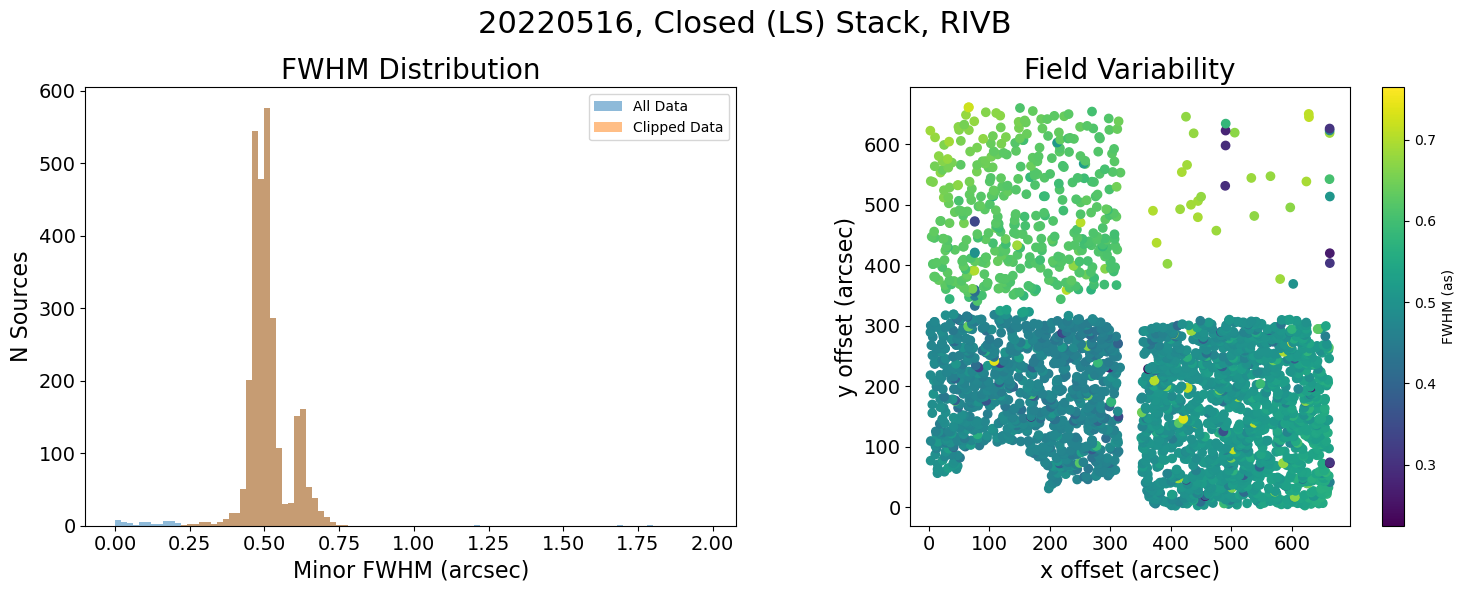

In [60]:
filt = 'RIVB'
img_file = stack_dir + f'fld2_stack_LS_c_{filt}.fits' 
starlist = stack_dir + f'fld2_stack_LS_c_{filt}_stars_stats_mdp.fits' 
plot_stats.plot_var(img_file, starlist, f"{night}, Closed (LS) Stack, {filt}")

### Closed (LS2)

Median FWHM           = 0.469"
Median FWHM (clipped) = 0.469"
Mean FWHM             = 1.569"
Mean FWHM (clipped)   = 0.488"
Stddev FWHM           = 14.650"
Stddev FWHM (clipped) = 0.064"


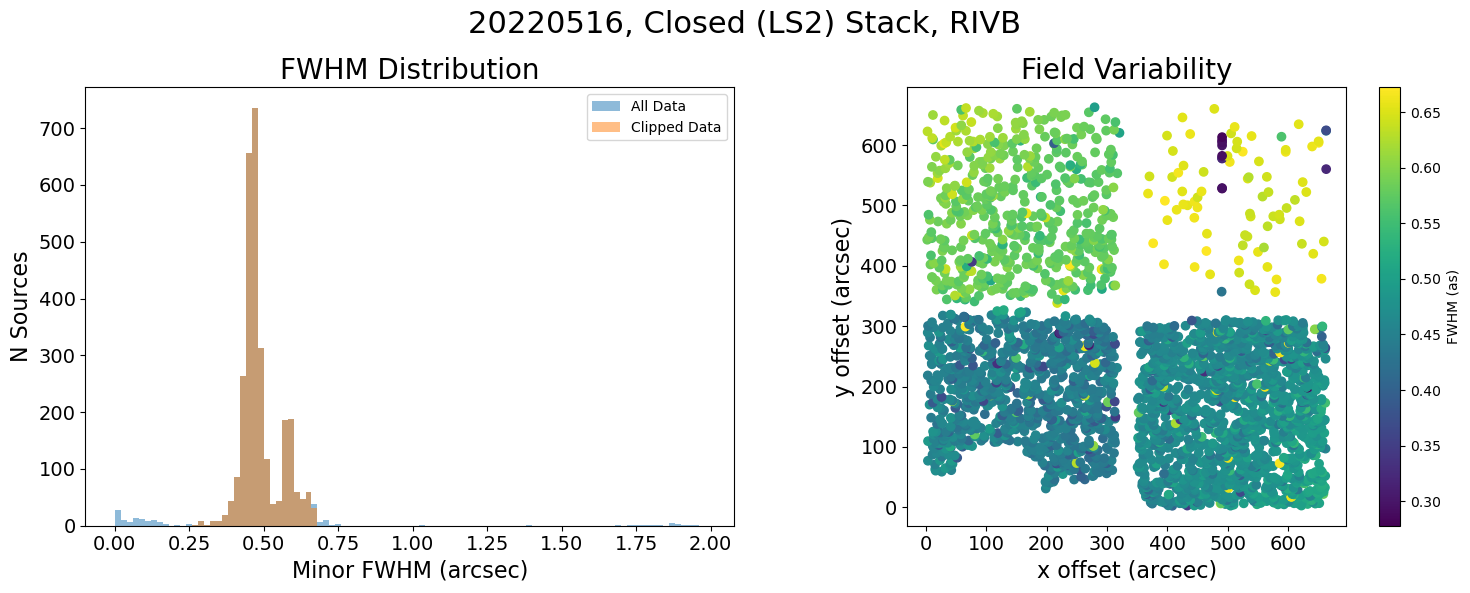

In [61]:
filt = 'RIVB'
img_file = stack_dir + f'fld2_stack_LS_c2_{filt}.fits' 
starlist = stack_dir + f'fld2_stack_LS_c2_{filt}_stars_stats_mdp.fits' 
plot_stats.plot_var(img_file, starlist, f"{night}, Closed (LS2) Stack, {filt}")

# Ect: Flats

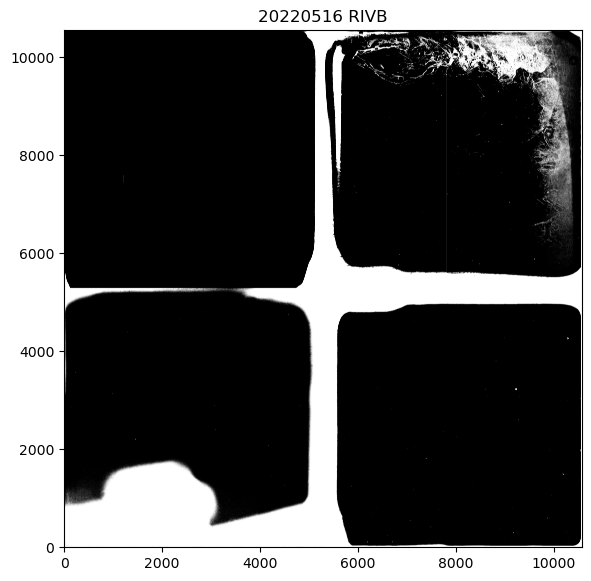

In [65]:
## What masks are we using? how are they different between orientations?
filt = 'RIVB'
data = fits.open(redu.calib_dir +  f"mask_{filt}.fits")[0].data

fig = plt.figure(figsize=(6,6))
plt.title(f"{redu.night} {filt}")
im = plt.imshow(data, origin ='lower', cmap='gray')
plt.tight_layout()
plt.show()